# Hyperparameter Tuning

In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from skimage import color
from torchvision import transforms
import torchvision.models as models
import ast
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import cohen_kappa_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pickle

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

class FundusDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        left_img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 3])
        right_img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 4])

        left_image = io.imread(left_img_name)
        right_image = io.imread(right_img_name)

        if len(left_image.shape) > 2 and left_image.shape[2] == 4:
            left_image = left_image[:, :, 0]
        if len(right_image.shape) > 2 and right_image.shape[2] == 4:
            right_image = right_image[:, :, 0]

        if left_image.shape[-1] != 3:
            left_image = np.repeat(left_image[:, :, np.newaxis], 3, axis=2)
        if right_image.shape[-1] != 3:
            right_image = np.repeat(right_image[:, :, np.newaxis], 3, axis=2)

        image_class = self.data_frame.iloc[idx, -1]
        image_class = ast.literal_eval(image_class)
        image_class = torch.tensor(image_class, dtype=torch.int64)
        one_hot_image_class = F.one_hot(image_class, num_classes=2).squeeze(0)

        if self.transform:
            left_image = self.transform(left_image)
            right_image = self.transform(right_image)

        if left_image.dim() == 2:
            left_image = left_image.unsqueeze(0)
        if right_image.dim() == 2:
            right_image = right_image.unsqueeze(0)

        sample = {'left_image': left_image, 'right_image': right_image, 'class': one_hot_image_class}

        return sample


In [4]:
# Subset Loading
train_subset_path = r"./OIA-ODIR/Training Set/Annotation/train_subset.csv"
valid_subset_path = r"./OIA-ODIR/Off-site Test Set/Annotation/valid_subset.csv"

# Set root directory paths
train_root_dir = r'./OIA-ODIR/Training Set/Images'
valid_root_dir = r'./OIA-ODIR//Off-site Test Set/Images'

# Transformed dataset for left and right fundus
transformed_dataset = {
    'train': FundusDataset(csv_file=train_subset_path, root_dir=train_root_dir, transform=transform),
    'validate': FundusDataset(csv_file=valid_subset_path, root_dir=valid_root_dir, transform=transform),
}


## Tuning

In [5]:
class LateFusionSUM_Resnet18(nn.Module):
    def __init__(self):
        super(LateFusionSUM_Resnet18, self).__init__()
        self.resnet18 = models.resnet18(weights='DEFAULT')
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()  # Remove the fully connected layer
        self.fc = nn.Linear(num_features, 512)  # Fusion layer
        self.classifiers = nn.ModuleList([nn.Linear(512, 2) for _ in range(8)])  # 8 classifiers for multi-label classification
        
    def forward(self, left, right):
        left_features = self.resnet18(left)
        right_features = self.resnet18(right)
        fused_features = left_features + right_features  # Element-wise sum fusion
        fused_features = self.fc(fused_features)
        outputs = [classifier(fused_features) for classifier in self.classifiers]
        return torch.stack(outputs, dim=1)

In [69]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

torch.manual_seed(42)
np.random.seed(42)

def train_model(model, dataloader, optimizer, criterion, num_epochs=30, verbose=True, save_path=None):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    kappa_dict = {'validate': []}
    f1_dict = {'validate': []}
    auc_dict = {'validate': []}
    best_f1 = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i+1, num_epochs))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
            all_probabilities_pos = []
            all_predictions = []
            all_labels = []
            all_labels_pos = []
                
            for data in dataloader[p]:
                optimizer.zero_grad()
                left_images = data['left_image'].to(device)
                right_images = data['right_image'].to(device)
                labels = data['class'].to(device)
                outputs = model(left_images, right_images)
                num_classifiers = outputs.size(1)
                classifier_losses = []
                epoch_loss = 0 
                for j in range(num_classifiers):
                    classifier_outputs = outputs[:, j, :]
                    classifier_labels = labels[:, j, :].squeeze(dim=1)  # Squeeze extra dimension
                    classifier_loss = criterion(classifier_outputs, classifier_labels.float())
                    classifier_losses.append(classifier_loss)
                
                loss = sum(classifier_losses)
                epoch_loss += loss.item()
                
                probabilities = torch.sigmoid(outputs)
                probabilities_pos = probabilities[:, :, 1]
                
                labels_pos = labels[:, :, 1]
                
                predictions = (probabilities > 0.5).int()
                
                all_probabilities_pos.extend(probabilities_pos.cpu().detach())
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_labels_pos.extend(labels_pos.cpu().detach())
                
                running_correct += torch.sum(predictions == labels).item()
                running_loss += loss.item()
                running_total += labels.size(0)
                if p== 'train':
                    loss.backward()
                    optimizer.step()
                
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f}'.format(p, epoch_loss))
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                all_labels_flat = np.concatenate(all_labels).flatten()
                all_predictions_flat = np.concatenate(all_predictions).flatten()
                stacked_labels_pos = torch.stack(all_labels_pos, dim=0)
                reshaped_labels_pos = stacked_labels_pos.view(stacked_labels_pos.shape[0], -1)
                stacked_prob_pos = torch.stack(all_probabilities_pos, dim=0)
                reshaped_prob_pos = stacked_prob_pos.view(stacked_prob_pos.shape[0], -1)
                reshaped_labels_pos = reshaped_labels_pos.numpy()
                reshaped_prob_pos = reshaped_prob_pos.numpy()

                fpr = {}
                tpr = {}
                thresholds = {}
                for i in range(8):
                    fpr[i], tpr[i], thresholds[i] = roc_curve(reshaped_labels_pos[:, i], reshaped_prob_pos[:, i])
                
                class_auc_scores = {}
                for i in range(8):
                    class_auc_scores[i] = auc(fpr[i], tpr[i])

                valid_auc_scores = [auc_score for auc_score in class_auc_scores.values() if not np.isnan(auc_score)]
                macro_auc_score = np.mean(valid_auc_scores)
                
                kappa = cohen_kappa_score(all_labels_flat, all_predictions_flat)
                f1 = f1_score(all_labels_flat, all_predictions_flat, average='macro')
                
                print('Kappa: {:.4f} F1: {:.4f} AUC: {:.4f}'.format(kappa, f1, macro_auc_score))
                
                kappa_dict[p].append(kappa)
                f1_dict[p].append(f1)
                auc_dict[p].append(macro_auc_score)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return acc_dict, loss_dict, kappa_dict, f1_dict, auc_dict

In [9]:
lr_list = [0.00001, 0.0001, 0.001, 0.01, 0.1]
bs_list = [8, 16]
file_path = "lfs_tuning_results.pkl"
lfs_results = []
for bs in bs_list:
    for lr in lr_list:
        dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True) for x in ['train', 'validate']}
        model = LateFusionSUM_Resnet18()
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        acc_dict, loss_dict, kappa_dict, f1_dict, auc_dict = train_model(model, dataloader, optimizer, criterion, num_epochs=30)
        lfs_results.append((lr, bs, acc_dict, loss_dict, kappa_dict, f1_dict, auc_dict))
        with open(file_path, 'wb') as file:
            pickle.dump(lfs_results, file)

Epoch: 1/30
----------
Phase:train, epoch loss: 0.6505
Phase:validate, epoch loss: 0.5831
Kappa: 0.5109 F1: 0.7538 AUC: 0.5000
Epoch: 2/30
----------
Phase:train, epoch loss: 0.4843
Phase:validate, epoch loss: 0.4716
Kappa: 0.6739 F1: 0.8369 AUC: 0.4866
Epoch: 3/30
----------
Phase:train, epoch loss: 0.3989
Phase:validate, epoch loss: 0.4157
Kappa: 0.6957 F1: 0.8478 AUC: 0.4955
Epoch: 4/30
----------
Phase:train, epoch loss: 0.3523
Phase:validate, epoch loss: 0.3874
Kappa: 0.6957 F1: 0.8478 AUC: 0.5357
Epoch: 5/30
----------
Phase:train, epoch loss: 0.3194
Phase:validate, epoch loss: 0.3719
Kappa: 0.7174 F1: 0.8587 AUC: 0.5446
Epoch: 6/30
----------
Phase:train, epoch loss: 0.2954
Phase:validate, epoch loss: 0.3633
Kappa: 0.7011 F1: 0.8505 AUC: 0.5446
Epoch: 7/30
----------
Phase:train, epoch loss: 0.2818
Phase:validate, epoch loss: 0.3578
Kappa: 0.7011 F1: 0.8505 AUC: 0.4777
Epoch: 8/30
----------
Phase:train, epoch loss: 0.2627
Phase:validate, epoch loss: 0.3535
Kappa: 0.7011 F1: 0.8

## Returning Highest F1 Score Across Epochs

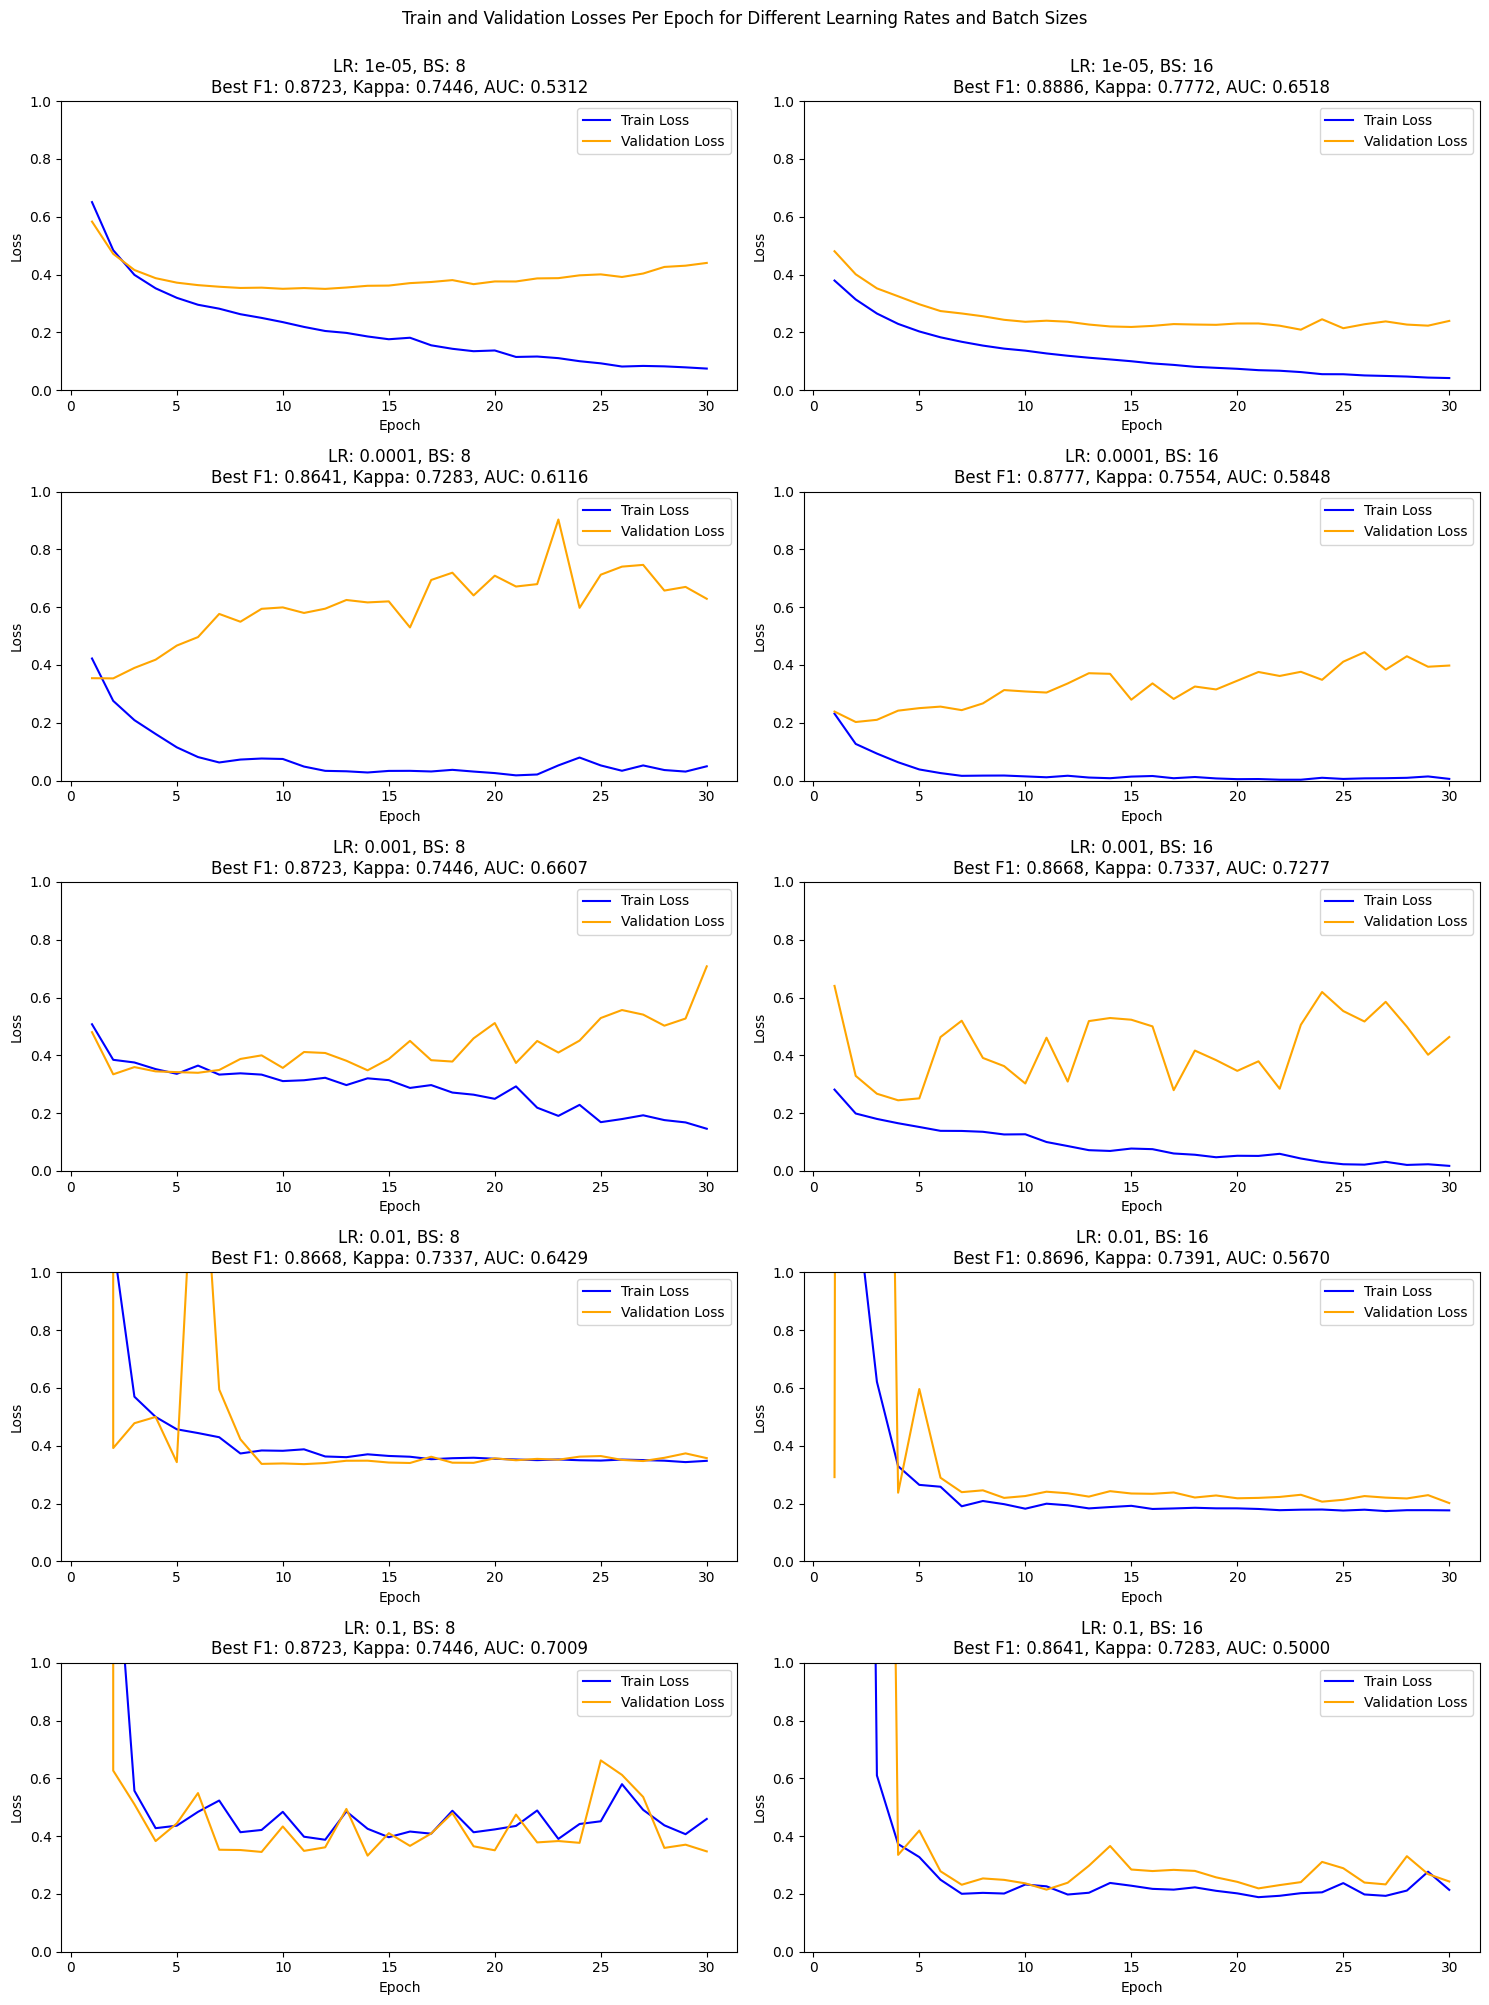

In [11]:
from collections import defaultdict

with open('./lfs_tuning_results.pkl', 'rb') as f:
    loaded_list = pickle.load(f)

lr_results = defaultdict(list)
for lr, bs, acc_dict, loss_dict, kappa_dict, f1_dict, auc_dict in loaded_list:
    lr_results[lr].append((bs, acc_dict, loss_dict, kappa_dict, f1_dict, auc_dict))

num_epochs = 30
fig, axs = plt.subplots(len(lr_results), 2, figsize=(15, 20))

for i, (lr, results) in enumerate(lr_results.items()):
    for j, (bs, acc_dict, loss_dict, kappa_dict, f1_dict, auc_dict) in enumerate(results):
        best_f1 = max(f1_dict['validate']) # select based on primary metric: f1
        best_epoch = f1_dict['validate'].index(best_f1) + 1
        kappa = kappa_dict['validate'][best_epoch - 1]
        auc = auc_dict['validate'][best_epoch - 1]

        axs[i, j].plot(range(1, num_epochs + 1), loss_dict['train'], label='Train Loss', color='blue')
        axs[i, j].plot(range(1, num_epochs + 1), loss_dict['validate'], label='Validation Loss', color='orange')
        axs[i, j].set_xlabel('Epoch')
        axs[i, j].set_ylabel('Loss')
        axs[i, j].set_ylim(0, 1)
        axs[i, j].set_title(f'LR: {lr}, BS: {bs}\nBest F1: {best_f1:.4f}, Kappa: {kappa:.4f}, AUC: {auc:.4f}')
        axs[i, j].legend()

fig.suptitle('Train and Validation Losses Per Epoch for Different Learning Rates and Batch Sizes', y=1)
plt.tight_layout()
plt.show()